# engine

> Simple engine that calculates gradients and backpropagates. Can be used in a simple neural net

In [ ]:
#| default_exp engine

In [ ]:
#| hide
from micrograd_nbdev.diagram import *
from nbdev.showdoc import *
from fastcore.test import *
import torch
import math

%load_ext autoreload
%autoreload 2

In [ ]:
#| export
class Value:
    def __init__(self,
                 data, # numeric value wrapped by `Value`
                 _children=(), # inputs to a given `Value`
                 _op='', # operation that resulted in a given `Value`
                 label='' # label for plotting graphs
                ):
        self.data = data
        self.grad = 0
        # Internal variables for graphviz
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label=''
    
    @staticmethod
    def _wrap(x):
        "Wrap x in Value"
        return x if isinstance(x, Value) else Value(x)
        
    def __add__(self, other):
        "self + other"
        other = self._wrap(other)
        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backward():
            self.grad += out.grad * 1 # global grad * local grad
            other.grad += out.grad * 1
        
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        "other + self"
        return self + other
    
    def __sub__(self, other):
        "self - other"
        return self + (-other)
    
    def __rsub__(self, other):
        "other - self"
        return other + (-self)
    
    def __mul__(self, other):
        "self * other"
        other = self._wrap(other)
        out = Value(self.data * other.data, (self, other), _op='*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        "other * mult"
        return self * other
 
    def __pow__(self, other):
        "self ** other. Other should be int or float"
        assert isinstance(other, (int,float)), f"{other} must be int or float"
        out = Value(self.data ** other, (self,), f"**{other}")
        
        def _backward():
            self.grad += out.grad * other * self.data**(other-1)
            
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        "self / other"
        return self * other**-1
    
    def __rtruediv__(self, other):
        "other / self"
        return other * self**-1
    
    def __neg__(self):
        "-self"
        return self *-1
    
    def tanh(self):
        "tanh"
        out = Value(math.tanh(self.data), (self,) , 'tanh')
        
        def _backward():
            self.grad += out.grad * (1-out**2)
        
        out._backward = _backward
        return out
        
    def relu(self):
        "relu"
        out = Value(max(self.data, 0), (self,), 'relu')
        
        def _backward():
            self.grad += out.grad * (1 if self.data > 0 else 0)
    
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        
        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    topo_sort(child)
                    # ipdb.set_trace()
                topo.append(node)
        topo_sort(self)
        
        # print(f"Topo list is {topo}")
        self.grad = 1
        # need to reverse because it topo returns nodes from left-to-right 
        for node in reversed(topo):
            node._backward()
        
    def __repr__(self):
        return f'Value(data={self.data}, grad={self.grad})'

### Test simple operations

In [ ]:
a = Value(-4.0)
b = Value(6.0)

test_eq((a+b).data, -4+6)
test_eq((a-b).data, -4-6)
test_eq((a/b).data, -4/6)
test_eq((a**2).data, (-4)**2)
test_eq(a.relu().data, 0)
test_eq(b.tanh().data, math.tanh(6.0))

### Test simple derivatives

In [ ]:
c = a*b
c.grad = 1
c._backward()
test_eq(b.grad, a.data)
test_eq(a.grad, b.data)

In [ ]:
a = Value(4.0)
b = a.relu()
b.grad = 1
b._backward()
test_eq(a.grad, 1)

In [ ]:
a = Value(2.0, label='a') # 2
b = Value(-3.0, label='b') # -3
c = Value(10.0, label='c') # 10
e = a*b; e.label = 'e' # -6
d = e + c; d.label = 'd' # 4
f = Value(-2.0, label='f') # -2
L = d*f; L.label='L' # -8
L

Value(data=-8.0, grad=0)

### Test Backward

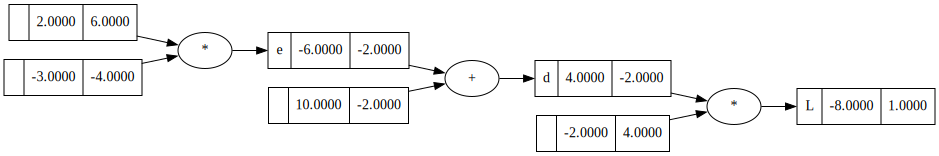

In [ ]:
L.backward()
draw_dot(L)

In [ ]:
x = Value(-4.0)
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y

Value(data=-20.0, grad=0)

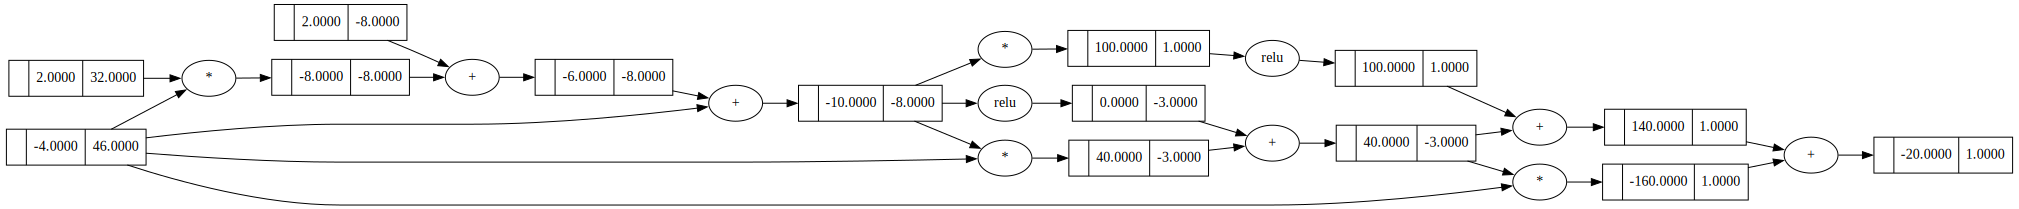

In [ ]:
y.backward()
draw_dot(y)

### Test forward and backward pass

In [ ]:
def test_1():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    test_eq(ymg.data, ypt.data.item())
    # backward pass went well
    test_eq(xmg.grad, xpt.grad.item())

In [ ]:
def test_2():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [ ]:
test_1()

In [ ]:
test_2()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()